# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [86]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import initializers
import random

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [87]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [88]:
# Extract the training and testing images and labels separately from the train and test dictionaries 
x_train = train['X']
y_train = train['y']

print(x_train.shape)
print(y_train.shape)

(32, 32, 3, 73257)
(73257, 1)


In [89]:
# Extract the testing images and labels separately from the train and test dictionaries 
x_test = test['X']
y_test = test['y']

print(x_test.shape)
print(y_test.shape)

(32, 32, 3, 26032)
(26032, 1)


In [90]:
# rehape x-train and x_test
x_train = x_train.transpose(3,0,1,2)
x_test = x_test.transpose(3,0,1,2)

print(x_train.shape)
print(x_test.shape)


(73257, 32, 32, 3)
(26032, 32, 32, 3)


In [91]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

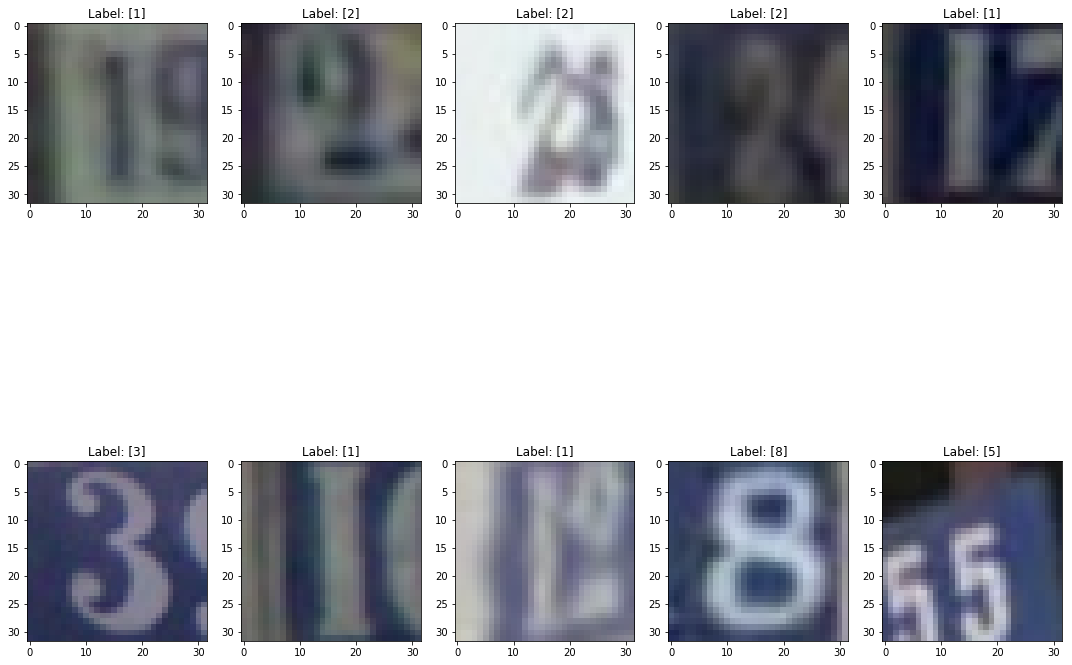

In [92]:
# Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
num = 10
num_row = 2

rand_indices = np.random.randint(0,x_train.shape[0],num)

num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(15,15))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train[rand_indices[i]], )
    ax.set_title('Label: {}'.format(y_train[rand_indices[i]]))
plt.tight_layout()
plt.show()

In [ ]:
# normalise X_train and X_test

x_train=x_train/255.
x_test=x_test/255.


In [93]:
# Convert the training and test images to grayscale by taking the average across all colour channels
# for each pixel.

x_train_grey = np.expand_dims (np.average(x_train, axis=-1), -1)
x_test_grey =  np.expand_dims (np.average(x_test, axis=-1), -1)
print(x_train_grey.shape)
print(x_test_grey.shape)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


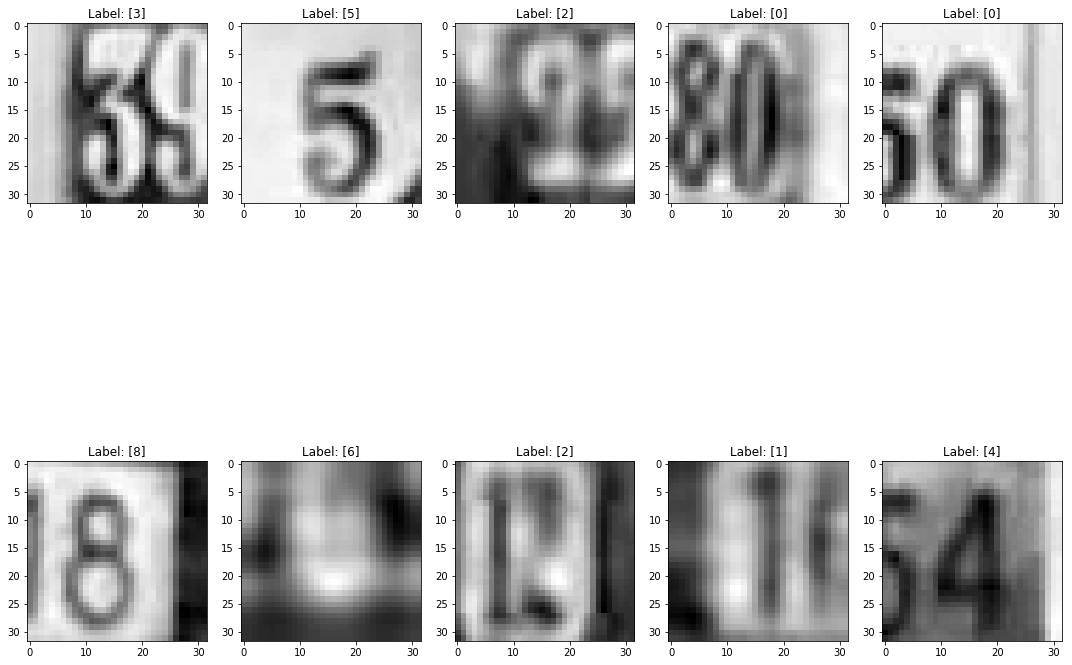

In [94]:
#* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
num = 10
num_row = 2

rand_indices = np.random.randint(0,x_train_grey.shape[0],num)

num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(15,15))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train_grey[rand_indices[i]].squeeze(axis=2), cmap='gray')
    ax.set_title('Label: {}'.format(y_train[rand_indices[i]]))
plt.tight_layout()
plt.show()

In [95]:
y_train_binarised = to_categorical(y_train.astype('int64'), 10)

y_test_binarised = to_categorical(y_test.astype('int64'), 10)

In [96]:
y_train_binarised[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [97]:
# Split train data to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train_grey, y_train_binarised
                                                                , train_size=0.85, random_state=42)

Build MLP Classifer

In [98]:
def MLPClassifer(input_shape):
    
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(512, activation = 'relu', kernel_initializer = initializers.RandomNormal(mean=0., stddev=0.1)),
        Dense(64, activation = 'relu', kernel_initializer = initializers.RandomNormal(mean=0., stddev=0.1)),
        Dense(32, activation = 'relu', kernel_initializer = initializers.RandomNormal(mean=0., stddev=0.1)),
        Dense(10, activation = 'softmax'),

    ])
    adam = tf.keras.optimizers.Adam(lr = 0.002)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [99]:
# create an instance of the MLP Classifer
model = MLPClassifer(x_train_grey[1].shape)

In [100]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 10)                330       
Total params: 560,042
Trainable params: 560,042
Non-trainable params: 0
_________________________________________________________________


In [101]:
checkpoint_filepath = '/tmp/checkpoint'
save_model_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy',save_freq='epoch',
                                                 save_best_only=True, save_weights_only=True,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                             factor=0.5, 
                             patience=3,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

In [102]:
history = model.fit(x_train_grey, y_train_binarised,validation_data=(X_val, y_val), 
                    epochs=25,callbacks=[save_model_checkpoint,reduce_lr ],verbose = 1, batch_size=64, validation_freq=1)

Train on 62268 samples, validate on 10989 samples
Epoch 1/25
62208/62268 [============================>.] - ETA: 0s - loss: 9.2184 - accuracy: 0.1671
Epoch 00001: val_accuracy improved from -inf to 0.26809, saving model to /tmp/checkpoint
62268/62268 [==============================] - 42s 673us/sample - loss: 9.2124 - accuracy: 0.1671 - val_loss: 2.3253 - val_accuracy: 0.2681
Epoch 2/25
62080/62268 [============================>.] - ETA: 0s - loss: 2.2404 - accuracy: 0.2908
Epoch 00002: val_accuracy improved from 0.26809 to 0.36418, saving model to /tmp/checkpoint
62268/62268 [==============================] - 37s 597us/sample - loss: 2.2396 - accuracy: 0.2910 - val_loss: 1.9829 - val_accuracy: 0.3642
Epoch 3/25
62080/62268 [============================>.] - ETA: 0s - loss: 1.7971 - accuracy: 0.3959
Epoch 00003: val_accuracy improved from 0.36418 to 0.47857, saving model to /tmp/checkpoint
62268/62268 [==============================] - 37s 588us/sample - loss: 1.7968 - accuracy: 0.3961

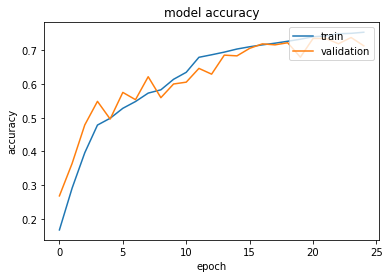

In [103]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

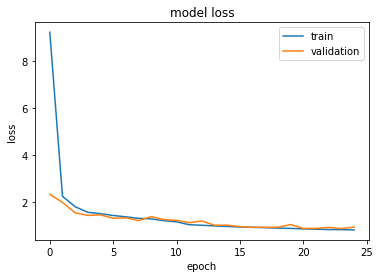

In [104]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [105]:
# * Compute and display the loss and accuracy of the trained model on the test set.
scores = model.evaluate(x_test_grey, y_test_binarised, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("loss: " ,  ( scores[0]))

accuracy: 69.39%
loss:  1.0285637338394464


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [125]:
def cnn_classifer(input_shape):
    
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    #adam = optimizers.Adam(lr = 0.001)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [126]:
# create an instance of the CNN Classifer
model = cnn_classifer(x_train_grey[1].shape)

In [130]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 576)             

In [131]:
checkpoint_filepath = 'checkpoint_cnn)'
save_model_checkpoint_CNN = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy',save_freq='epoch',
                                                 save_best_only=True, save_weights_only=True)


early_stopping_CNN = EarlyStopping(monitor='val_accuracy', patience=3)

In [132]:
history = model.fit(x_train_grey, y_train_binarised,validation_data=(X_val, y_val), 
                    epochs=5,callbacks=[save_model_checkpoint_CNN,early_stopping_CNN],
                    verbose = 1, batch_size=64, validation_freq=1)

Train on 73257 samples, validate on 10989 samples
Epoch 1/5
73257/73257 [==============================] - 311s 4ms/sample - loss: 0.5459 - accuracy: 0.8315 - val_loss: 0.4312 - val_accuracy: 0.8676
Epoch 2/5
73257/73257 [==============================] - 298s 4ms/sample - loss: 0.4988 - accuracy: 0.8480 - val_loss: 0.4815 - val_accuracy: 0.8598
Epoch 3/5
73257/73257 [==============================] - 299s 4ms/sample - loss: 0.4667 - accuracy: 0.8572 - val_loss: 0.3220 - val_accuracy: 0.9008
Epoch 4/5
73257/73257 [==============================] - 299s 4ms/sample - loss: 0.4488 - accuracy: 0.8600 - val_loss: 0.3274 - val_accuracy: 0.9028
Epoch 5/5
73257/73257 [==============================] - 299s 4ms/sample - loss: 0.4326 - accuracy: 0.8675 - val_loss: 0.2816 - val_accuracy: 0.9141


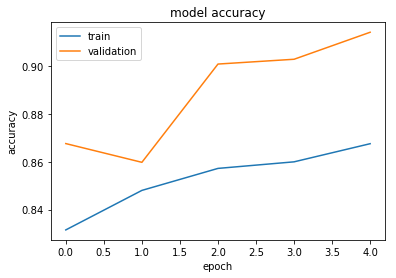

In [135]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

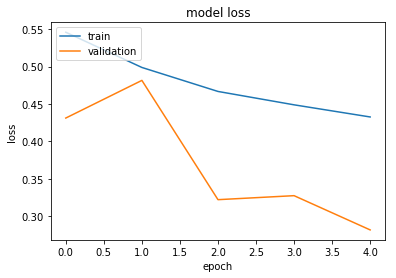

In [136]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [137]:
# * Compute and display the loss and accuracy of the trained model on the test set.
scores = model.evaluate(x_test_grey, y_test_binarised, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("loss: " ,  ( scores[0]))

accuracy: 88.61%
loss:  0.37976543343389557


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [196]:
# inialize the MLP Classifer
mlp_model = MLPClassifer(x_train_grey[1].shape)
mlp_model.load_weights('/tmp/checkpoint')

In [197]:
# inialize the CNN Classifer
cnn_model = cnn_classifer(x_train_grey[1].shape)
cnn_model.load_weights('checkpoint_cnn)')

In [198]:
# selecting 5 random images from the test set and displaying them in a figure - MLP
index_images = list(np.random.randint(0, x_test_grey.shape[0], [5]))




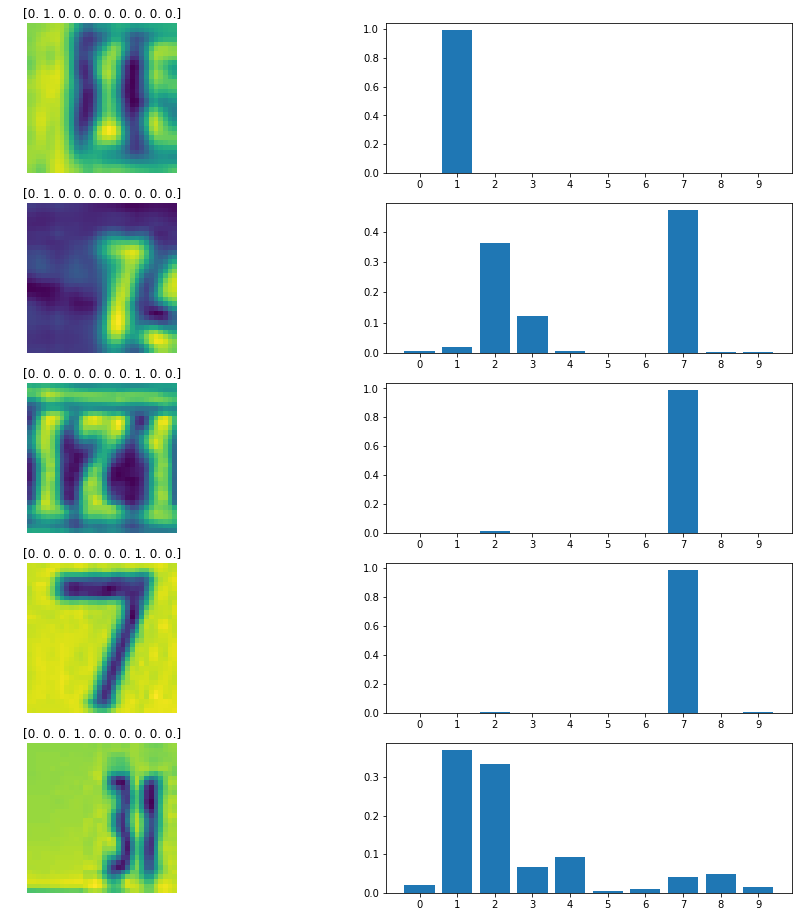

In [199]:
#make prediction using the loaded models
predictions_mlp_model = mlp_model.predict(x_test_grey[index_images])
# showing MLP results
fig = plt.figure(figsize=(16, 16))
for i in range(5):
    fig.add_subplot(5, 2, 1+i*2)
    plt.axis('off')
    plt.imshow(x_test_grey[index_images[i],:,:,:].squeeze(axis=2))
    plt.title(y_test_binarised[index_images[i]]%10)
    fig.add_subplot(5, 2, (i+1)*2)
    pred = list(predictions_mlp_model[i])
    plt.bar(list(np.arange(10)), pred)
    plt.xticks(list(np.arange(10)))
plt.show()

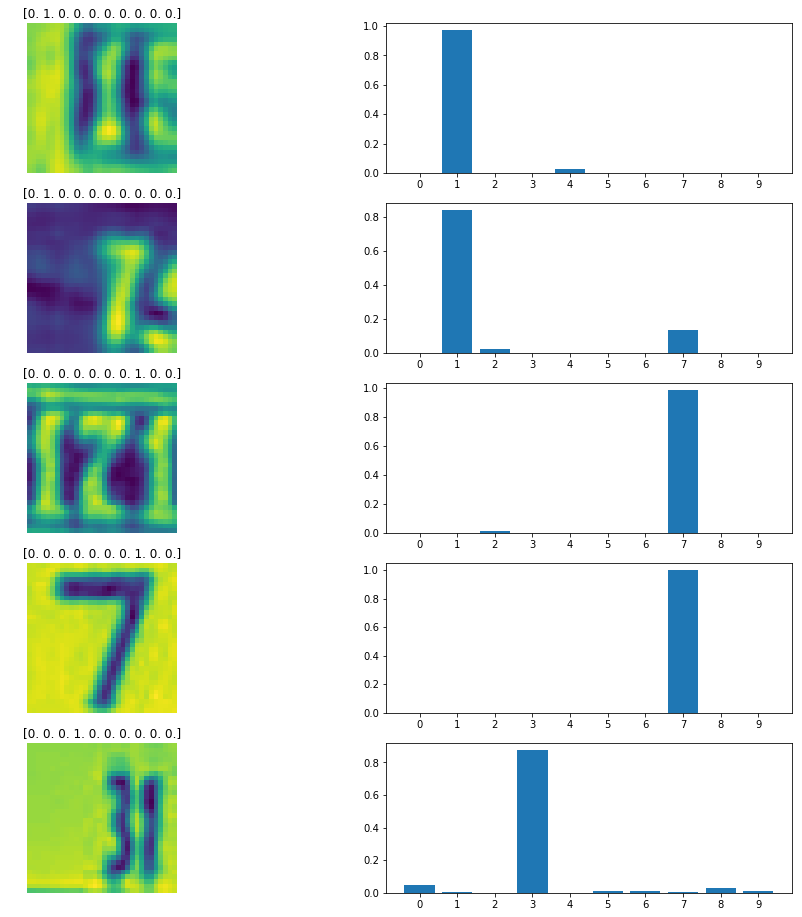

In [200]:
predictions_cnn_model = cnn_model.predict(x_test_grey[index_images])
# showing CNN results
fig = plt.figure(figsize=(16, 16))
for i in range(5):
    fig.add_subplot(5, 2, 1+i*2)
    plt.axis('off')
    plt.imshow(x_test_grey[index_images[i],:,:,:].squeeze(axis=2))
    plt.title(y_test_binarised[index_images[i]]%10)
    fig.add_subplot(5, 2, (i+1)*2)
    pred = list(predictions_cnn_model[i])
    plt.bar(list(np.arange(10)), pred)
    plt.xticks(list(np.arange(10)))
plt.show()